# Asymp app version of fig 3

Asymp

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

from math import log, floor

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    get_dose_colors
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import trait_vec, gamma_dist, get_dist_mean, get_best_dose_for_cb
from poly2.config import Config,  get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote
from poly2.consts import FUNG_DECAY_RATE, MUTATION_PROP, MUTATION_SCALE

C:\Users\user\anaconda3\envs\poly2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Need to show why high mutation scale could incentivise lower dose

In [3]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize

In [18]:
pars = pd.DataFrame({
    'asymp_mu': 0.6,
    'asymp_b': 10,
    'curv': 10,
    'dec_rate': 0.33,
    'm_prop': 1,
    'm_scale': 1,
}, index=[0])

pars

,asymp_mu,asymp_b,curv,dec_rate,m_prop,m_scale
0,0.6,10,10,0.33,1,1


In [19]:
pars.iloc[0].to_dict()

{'asymp_mu': 0.6,
 'asymp_b': 10.0,
 'curv': 10.0,
 'dec_rate': 0.33,
 'm_prop': 1.0,
 'm_scale': 1.0}

In [20]:
from poly2.config import get_asymptote_config
from poly2.simulator import SimulatorAsymptote

In [21]:
cf = get_asymptote_config(n_years=35, n_k=300, verbose=False)

In [22]:
cf.k_mu = pars.asymp_mu.values[0]
cf.k_b = pars.asymp_b.values[0]
cf.curvature = pars.curv.values[0]
cf.decay_rate = FUNG_DECAY_RATE * pars.dec_rate.values[0]
cf.mutation_proportion = MUTATION_PROP * pars.m_prop.values[0]
cf.mutation_scale_fung = MUTATION_SCALE * pars.m_scale.values[0]

In [23]:
cf.print_repr()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
curvature = 10
decay_rate = 0.0029716500000000006
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
k_b = 10
k_mu = 0.6
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0198361584016981
n_k = 300
n_years = 35
sprays = None



In [24]:
%%time

datas = []

for dose in tqdm(np.linspace(0.1, 1, 2)):

    cf.doses = dose*np.ones(cf.n_years)

    data = SimulatorAsymptote(cf).run_model()
    
    datas.append(data)
    
# datas

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:24<00:00, 42.13s/it]

Wall time: 1min 24s


In [25]:
doses = [0.1, 1]

In [26]:
line_df = pd.concat([
    pd.DataFrame(dict(
        year = np.arange(1,36),
        yld = datas[ii]['yield_vec'],
        dose = doses[ii]
    ))
    for ii in range(2)
]
)

In [27]:
line_df

,year,yld,dose
0,1,10.166882,0.1
1,2,10.134428,0.1
2,3,10.098929,0.1
3,4,10.060791,0.1
4,5,10.020576,0.1
...,...,...,...
30,31,8.828338,1.0
31,32,8.827978,1.0
32,33,8.827653,1.0
33,34,8.827358,1.0


In [32]:
bd = get_best_dose_for_cb(line_df, 10.55, eps=0.2)

In [33]:
bd.describe()

,dose,year,yy
count,70.000000,70.000000,7.000000e+01
mean,0.331429,18.000000,1.055000e+01
std,0.396193,10.174421,8.945913e-15
min,0.100000,0.800000,1.055000e+01
25%,0.100000,9.350000,1.055000e+01
50%,0.100000,18.000000,1.055000e+01
75%,0.775000,26.650000,1.055000e+01
max,1.000000,35.200000,1.055000e+01


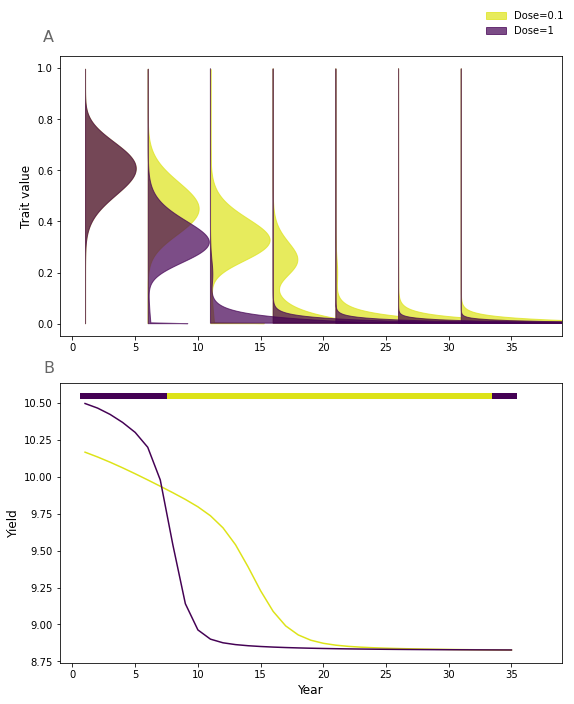

In [34]:
f, ax = plt.subplots(2, 1, figsize=(8,10))

colrs = get_dose_colors(20)
cols = [colrs[1], colrs[-1]]
# cols = get_dose_colors(2)

labels = ['Dose=0.1', 'Dose=1']

for ii in range(2):
    ax[1].plot(
        np.arange(1, 36),
        datas[ii]['yield_vec'],
        c=cols[ii],
    )
    
    ax[1].plot(
        bd.loc[lambda x: x.dose==doses[1-ii]].year,
        bd.loc[lambda x: x.dose==doses[1-ii]].yy,
        c=cols[1-ii],
        lw=6
    )
    
    for yy in range(0, 35, 5):

        if yy==0:
            label=labels[ii]
        else:
            label=None

        ax[0].fill_betweenx(
            datas[ii]['k_vec'],
            np.repeat(1+yy, 300),
            np.repeat(1+yy, 300) + 300*datas[ii]['fung_dists'][:, yy],
            color=cols[ii],
            alpha=0.7,
            label=label,
        )

ax[0].set_xlim([-1, 39])
ax[1].set_xlim([-1, 39])

ax[0].set_ylabel('Trait value')

ax[1].set_xlabel('Year')
ax[1].set_ylabel('Yield')

plt.tight_layout(rect=[0,0,1,0.92], h_pad=3)

f.legend(
    loc=1,
    bbox_to_anchor=(1,0.98),
    frameon=False
)

get_corner_annotations(1, 2, 0.075, 0.92, 0.1, 0.46, plt)

In [35]:
f.savefig('../figures/paper/thesis_fig12.jpg', dpi=600, bbox_inches="tight")